# Continuous LQR
## Example on 17-14 -- Second order problem

This notebook explores the role of $R_N$ in the $P(t)$ and the differences in state response in using $K_{ss}$ and $K(t)$ in the feeback control.

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

import random, sys
import scipy.linalg
from scipy.integrate import odeint,solve_ivp
from scipy.interpolate import interp1d

from sympy import Matrix, init_printing
init_printing()

Running Python: 3.8.16


### Problem Definition

In [2]:
dt = 1e-3                             # integration delta t
Tf = 10                               # final time  
Npts = round(Tf/dt)                   # number of integration pts    
t = np.linspace(0,Tf,Npts)
tau = Tf - t                          # backwards time for P matrix

In [3]:
A = np.array([[0, 1], [0, 1]])      # dynamics matrix
n,_ = A.shape
B = np.array([[0], [1]])              # input matrix
RN = np.array([[0, 0], [0, 4]])        # terminal state cost 
P = np.zeros((n,n,Npts))              # cost to go matrix
Rxx = np.array([[1, 0], [0, 0]])      # state cost in LQR
Ruu = np.array([3])                     # control cost in LQR

### Integration of $P(t)$

In [4]:
def doty(y, t, A, B, Rxx, Ruu):
    n,_ = A.shape
    P = y.reshape(n,n)
    P = (P + P.T)/2                   # make sure that P is symmetric
    dotP = P@A + A.T@P + Rxx - np.multiply(P@B,np.linalg.inv(np.atleast_2d(Ruu)))@B.T@P
    return dotP.reshape(n**2,)
    
# integrate P forward in tau (backward in t) from H
sol = odeint(doty, RN.reshape(2*n,), t, args=(A, B, Rxx, Ruu))
K_ss, P_ss = lqr(A, B, Rxx, Ruu)

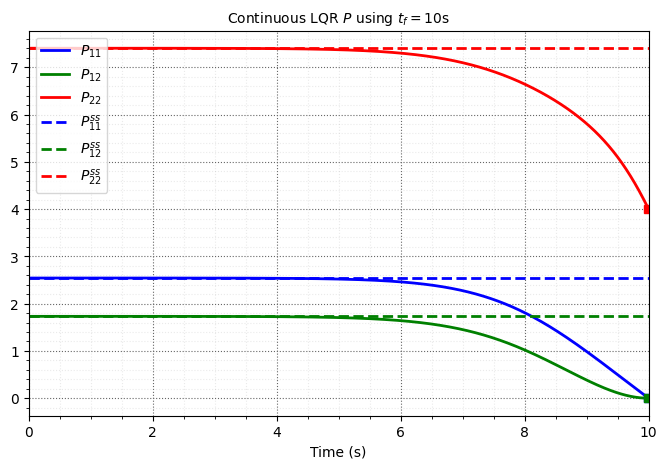

In [5]:
plt.figure(2,figsize=(8,5))
plt.plot(tau, sol[:, 0], 'b', label=r'$P_{11}$')
plt.plot(tau, sol[:, 1], 'g', label=r'$P_{12}$')
plt.plot(tau, sol[:, 3], 'r', label=r'$P_{22}$')
plt.plot([0,Tf],[P_ss[0,0],P_ss[0,0]],'b--',label=r'$P^{ss}_{11}$')
plt.plot([0,Tf],[P_ss[0,1],P_ss[0,1]],'g--',label=r'$P^{ss}_{12}$')
plt.plot([0,Tf],[P_ss[1,1],P_ss[1,1]],'r--',label=r'$P^{ss}_{22}$')
plt.plot(0.999*Tf,RN[0,0],'bs')
plt.plot(0.999*Tf,RN[0,1],'gs')
plt.plot(0.999*Tf,RN[1,1],'rs')
plt.legend(loc=2)
plt.title('Continuous LQR $P$ using $t_f=$'+str(Tf)+'s')
plt.xlim([0,Tf])
plt.xlabel(r'Time (s)')
nicegrid()
plt.savefig("figs/CLQR_ex2_1.png")
plt.show()

### Steady State $P$

P steady state value


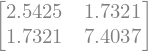

compare to P Numerical


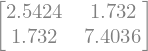

Computed Steady State Gain K


Compare to Numerical Gain K


In [6]:
print('P steady state value')
display(Matrix(np.round(P_ss,4)))

print('compare to P Numerical')
display(Matrix(np.round(sol[-1,:].reshape(n,n),4)))

print(r'Computed Steady State Gain K')
display(Matrix(np.round(K_ss,4)))

K = np.zeros((Ruu.size,n,Npts))
for II in np.arange(0,Npts):
    K[:,:,Npts-1-II] = np.linalg.inv(np.atleast_2d(Ruu))@B.T@sol[II,:].reshape(n,n)

print('Compare to Numerical Gain K')
display(Matrix(np.round(K[0,:,0],4)).T)

### Gains $K(t)$

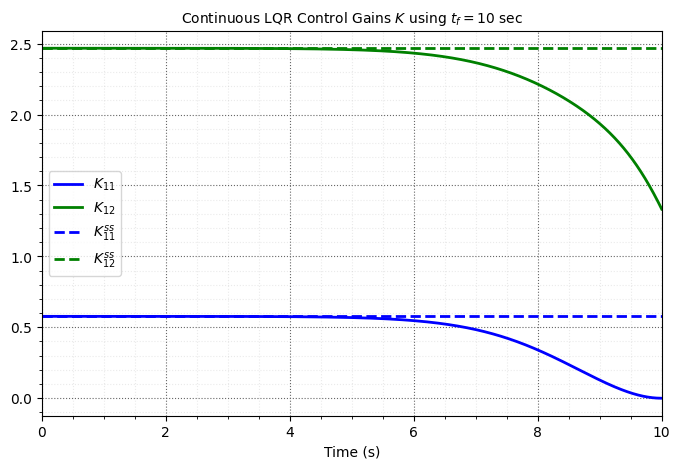

In [7]:
plt.figure(3,figsize=(8,5))
plt.plot(t[0:],K[0,0,:], 'b', label=r'$K_{11}$')
plt.plot(t[0:],K[0,1,:], 'g', label=r'$K_{12}$')
plt.plot([0,Tf],[K_ss[0,0],K_ss[0,0]],'b--',label=r'$K^{ss}_{11}$')
plt.plot([0,Tf],[K_ss[0,1],K_ss[0,1]],'g--',label=r'$K^{ss}_{12}$')
plt.legend()
plt.xlim([0,Tf])
plt.title('Continuous LQR Control Gains $K$ using $t_f=$'+str(Tf)+' sec')
plt.xlabel(r'Time (s)')
nicegrid()
plt.savefig("figs/CLQR_ex2_2.png")
plt.show()

## Forward Simulation of state response with cts LQR 

In [8]:
x0 = np.array([1, 1])    # state initial condition
X = np.zeros((n,1,Npts))
X_ss = np.zeros((n,1,Npts))
U = np.zeros((1,1,Npts-1))
U_ss = np.zeros((1,1,Npts-1))
X[:,0,0] = x0
X_ss[:,0,0] = x0

Acl_ss = A - B@K_ss

for k in np.arange(0,Npts-1):
    Acl = A - B@K[:,:,k]
    U[:,0,k] = K[:,:,k]@X[:,0,k]
    U_ss[:,0,k] = K_ss@X_ss[:,0,k]
    X[:,0,k+1] = X[:,0,k] + dt*Acl@X[:,0,k]
    X_ss[:,0,k+1] = X_ss[:,0,k] + dt*Acl_ss@X_ss[:,0,k]

In [9]:
def Compute_cost(Npts,Tf,dt,X,U,H,Rxx,Ruu):
    t_int = np.linspace(0,Tf-dt,Npts-1)
    U_int = interp1d(x = t_int, y = U, kind='zero')
    X0_int = interp1d(x = t_int, y = X[0,:,:-1], kind='zero')
    X1_int = interp1d(x = t_int, y = X[1,:,:-1], kind='zero')

    Jtf = np.array([0.5*X[:,0,-1].T@RN@X[:,0,-1]])

    def Jderiv(t,T,X0,X1,U,Rxx,Ruu):
        x = np.array([X0(t), X1(t)]).reshape(n,1)
        u = np.array([U(t)])
        deriv = x.T@Rxx@x + u.T*Ruu*u
        return 0.5*deriv

    JJ = solve_ivp(Jderiv, [0, Tf-dt], Jtf, t_eval=[Tf-dt], rtol=1e-9, args=(X0_int,X1_int,U_int,Rxx,Ruu))
    return JJ.y.flatten()[-1]

J = Compute_cost(Npts,Tf,dt,X,U,RN,Rxx,Ruu)
J_ss = Compute_cost(Npts,Tf,dt,X_ss,U_ss,RN,Rxx,Ruu)
print(f'LQR Cost using Optimal Control {J:6.4f}')
print(f'LQR Cost using Steady State Control {J_ss:6.4f}')

Jp = (x0.reshape(n,1).T@sol[-1,:].reshape(n,n)@x0.reshape(n,1)/2).flatten()
print(f'Check cost value using numerical CTG matrix {Jp[0]:6.4f}')

LQR Cost using Optimal Control 6.7107
LQR Cost using Steady State Control 6.7105
Check cost value using numerical CTG matrix 6.7051


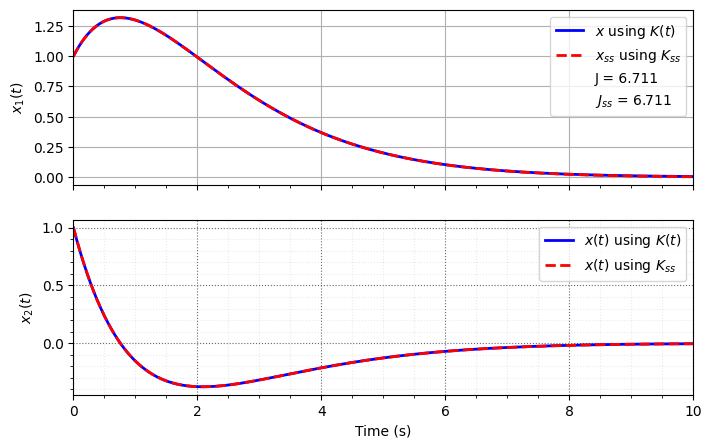

In [10]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8,5), sharex='col', sharey='row')

ax1.plot(t[0:],X[0,0,:],'b-',label=r'$x$ using $K(t)$')
ax1.plot(t[0:],X_ss[0,0,:],'r--',label=r'$x_{ss}$ using $K_{ss}$')
ax1.set_ylabel(r'$x_1(t)$')
nicegrid()
ax1.set_xlim([0,Tf])
ax1.plot(np.NaN, np.NaN, '-', color='none', label='J = '+str(round(J,3)))
ax1.plot(np.NaN, np.NaN, '-', color='none', label=r'$J_{ss}$ = '+str(round(J_ss,3)))
ax1.legend(loc='best')

ax2.plot(t,X[1,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax2.plot(t,X_ss[1,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
ax2.set_ylabel(r'$x_2(t)$')
ax2.legend(loc='best')
ax2.set_xlim([0,Tf])
nicegrid()
ax2.set_xlabel(r'Time (s)')
plt.savefig("figs/CLQR_ex2_3.png")
plt.show()

## Analysis of $R_N$ weighting on closed-loop response

In [11]:
def f(logbeta = 0, Tf = 10):
    Npts = round(Tf/dt)
    t = np.linspace(0,Tf,Npts)
    tau = Tf - t                         # backwards time for P matrix

    sol = odeint(doty, (10**logbeta)*RN.reshape(2*n,), t, args=(A, B, Rxx, Ruu))   
    P_ss = la.solve_continuous_are(A, B, Rxx, Ruu)
    K_ss = np.linalg.inv(np.atleast_2d(Ruu))@B.T@P_ss

    K = np.zeros((Ruu.size,n,Npts))
    for II in np.arange(Npts):
        K[:,:,Npts-1-II] = np.linalg.inv(np.atleast_2d(Ruu))@B.T@sol[II,:].reshape(n,n)
      
    X = np.zeros((n,1,Npts))
    X_ss = np.zeros((n,1,Npts))
    U = np.zeros((1,1,Npts-1))
    U_ss = np.zeros((1,1,Npts-1))
    X[:,0,0] = x0
    X_ss[:,0,0] = x0
    Acl_ss = A - B@K_ss

    for k in np.arange(Npts-1):
        Acl = A - B@K[:,:,k]
        U[:,0,k] = K[:,:,k]@X[:,0,k]
        U_ss[:,0,k] = K_ss@X_ss[:,0,k]
        X[:,0,k+1] = X[:,0,k] + dt*Acl@X[:,0,k]
        X_ss[:,0,k+1] = X_ss[:,0,k] + dt*Acl_ss@X_ss[:,0,k]

    J = Compute_cost(Npts,Tf,dt,X,U,np.array([10.0**logbeta])*RN,Rxx,Ruu)
    J_ss = Compute_cost(Npts,Tf,dt,X_ss,U_ss,np.array([10.0**logbeta])*RN,Rxx,Ruu)

    fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(8,8), sharex='col', sharey='row')
    ax1.plot(t[0:],X[0,0,:],'b-',label=r'$x(t)$ using $K(t)$')
    ax1.plot(t[0:],X_ss[0,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
    ax1.plot(np.NaN, np.NaN, '-', color='none', label='J = '+str(round(J,3)))
    ax1.plot(np.NaN, np.NaN, '-', color='none', label=r'$J_{ss}$ = '+str(round(J_ss,3)))
    ax1.set_xlim(0,Tf)
    ax1.set_ylabel(r'$x_1(t)$')
    nicegrid()
    ax1.legend(loc='best')
    ax1.set_title(r'Impact of Terminal weight $H$ on response')

    ax2.plot(t,X[1,0,:],'b-',label=r'$x(t)$ using $K(t)$')
    ax2.plot(t,X_ss[1,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
    ax2.set_ylabel(r'$x_2(t)$')
    ax2.legend(loc='best')
    nicegrid()
    
    ax3.plot(tau, sol[:, 0], 'b', label=r'$P_{11}$')
    ax3.plot(tau, sol[:, 3], 'r', label=r'$P_{22}$')
    ax3.plot([0,Tf],[P_ss[0,0],P_ss[0,0]],'b--',label=r'$P^{ss}_{11}$')
    ax3.plot([0,Tf],[P_ss[1,1],P_ss[1,1]],'r--',label=r'$P^{ss}_{22}$')
    ax3.legend()
    ax3.set_xlabel(r'Time (s)')
    nicegrid()
    plt.show()

interactive_plot = interactive(f, {'manual': False}, logbeta=(-1,6,0.5), Tf=(.5,10,.5))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='logbeta', max=6.0, min=-1.0, step=0.5), FloatSlider(…

### Continuous Time LQR Observations:

- If $t_f$ is long (here $>3$), then $x(t)$ response using $K_{ss}$ and $K(t)$ are very similar for much of the time and even a large terminal penalty $\beta R_N$ tends to only impact the very end of the trajectory

- If $t_f$ is short (here $<3$), then large $\beta R_N$ begins to dominate the response, and $K_{ss}$ response is stable, but clearly suboptimal

## Analysis of $R_{uu}$ weighting on closed-loop response

In [12]:
Npts = round(Tf/dt)
t = np.linspace(0,Tf,Npts)
tau = Tf - t                         # backwards time for P matrix
x0 = np.array([1, 1])    # state initial condition

def f(logRuu = 0):
    RN = np.array([[0, 0], [0, 0]])        # terminal state cost 
    Ruu = np.array(2)*(10**logRuu)
    sol = odeint(doty, RN.reshape(2*n,), t, args=(A, B, Rxx, Ruu))   
    P_ss = la.solve_continuous_are(A, B, Rxx, Ruu)
    K_ss = np.linalg.inv(np.atleast_2d(Ruu))@B.T@P_ss

    K = np.zeros((Ruu.size,n,Npts))
    for II in np.arange(Npts):
        K[:,:,Npts-1-II] = np.linalg.inv(np.atleast_2d(Ruu))@B.T@sol[II,:].reshape(n,n)
      
    X = np.zeros((n,1,Npts))
    X_ss = np.zeros((n,1,Npts))
    U = np.zeros((1,1,Npts-1))
    U_ss = np.zeros((1,1,Npts-1))
    X[:,0,0] = x0
    X_ss[:,0,0] = x0
    Acl_ss = A - B@K_ss

    for k in np.arange(Npts-1):
        Acl = A - B@K[:,:,k]
        U[:,0,k] = K[:,:,k]@X[:,0,k]
        U_ss[:,0,k] = K_ss@X_ss[:,0,k]
        X[:,0,k+1] = X[:,0,k] + dt*Acl@X[:,0,k]
        X_ss[:,0,k+1] = X_ss[:,0,k] + dt*Acl_ss@X_ss[:,0,k]

    J = Compute_cost(Npts,Tf,dt,X,U,RN,Rxx,Ruu)
    J_ss = Compute_cost(Npts,Tf,dt,X_ss,U_ss,RN,Rxx,Ruu)

    fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(8,8), sharex='col', sharey='row')
    ax1.plot(t[0:],X[0,0,:],'b-',label=r'$x(t)$ using $K(t)$')
    ax1.plot(t[0:],X_ss[0,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
    ax1.plot(np.NaN, np.NaN, '-', color='none', label='J = '+str(round(J,3)))
    ax1.plot(np.NaN, np.NaN, '-', color='none', label=r'$J_{ss}$ = '+str(round(J_ss,3)))
    ax1.set_xlim(0,Tf)
    plt.title('CTS LQR with $R_{uu}=2 \cdot 10^{( '+str(logRuu)+')}$')
    ax1.set_ylabel(r'$x_1(t)$')
    nicegrid()
    ax1.legend(loc='best')

    ax2.plot(t,X[1,0,:],'b-',label=r'$x(t)$ using $K(t)$')
    ax2.plot(t,X_ss[1,0,:],'r--',label=r'$x(t))$ using $K_{ss}$')
    ax2.set_ylabel(r'$x_2(t)$')
    ax2.legend(loc='best')
    nicegrid()
    
    ax3.plot(tau, sol[:, 0], 'b', label=r'$P_{11}$')
    ax3.plot(tau, sol[:, 3], 'r', label=r'$P_{22}$')
    ax3.plot([0,Tf],[P_ss[0,0],P_ss[0,0]],'b--',label=r'$P^{ss}_{11}$')
    ax3.plot([0,Tf],[P_ss[1,1],P_ss[1,1]],'r--',label=r'$P^{ss}_{22}$')
    ax3.legend()
    ax3.set_xlabel(r'Time (s)')
    #ax3.set_ylim(0,2)
    nicegrid()
    plt.show()

interactive_plot = interactive(f, {'manual': False}, logRuu=(-6,6,1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='logRuu', max=6, min=-6), Output()), _dom_classes=('widge…